In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import pickle
import os
import csv
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statistics import mean
warnings.filterwarnings('ignore')

In [2]:
sds_results_list = [f.name for f in os.scandir("../Avila_SDS/pickle/") if f.is_dir()==False]
sds_results = {}

In [6]:
original_dataset=pd.read_csv('../Ex-Jobb/avila-tr.txt', na_values=["?"])
original_dataset.columns = ["Int_Dist","Up_Marg","Lo_Marg","Exploit","Row_Num","Mod_Ratio","Int_Spac","Weight","Peak_Num","MR/IS","Class"]
original_dataset

,Int_Dist,Up_Marg,Lo_Marg,Exploit,Row_Num,Mod_Ratio,Int_Spac,Weight,Peak_Num,MR/IS,Class
0,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
1,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
2,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
3,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F
4,0.117948,-0.220579,-3.210528,-1.623238,0.261718,-0.349509,0.257927,-0.385979,-0.247731,-0.331310,A
...,...,...,...,...,...,...,...,...,...,...,...
10424,0.080916,0.588093,0.015130,0.002250,0.261718,-0.557133,0.371178,0.932346,0.282354,-0.580141,F
10425,0.253730,-0.338346,0.352988,-1.154243,0.172340,-0.557133,0.257927,0.348428,0.032902,-0.527134,F
10426,0.229043,-0.000745,0.171611,-0.002793,0.261718,0.688613,0.295677,-1.088486,-0.590727,0.580142,A
10427,-0.301743,0.352558,0.288973,1.638181,0.261718,0.688613,0.069175,0.502761,0.625350,0.718969,E


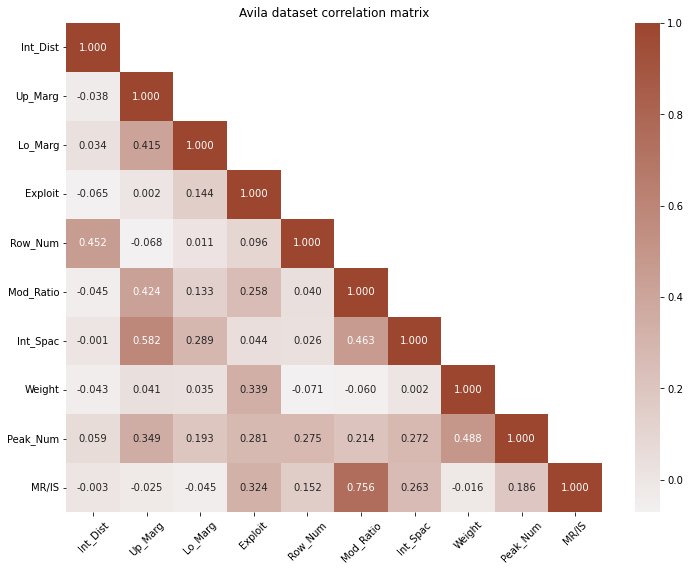

In [7]:
#test correlation between variables
corr = original_dataset.corr()
hm_fig, hm_ax = plt.subplots(figsize=(12,9))
mask = np.logical_not(np.tril(np.ones_like(corr, dtype=np.bool)))
sns.heatmap(
    corr,
    annot=True,
    mask=mask,
    fmt='.3f',
    ax=hm_ax,
    cmap=sns.light_palette('#9c462f', n_colors=300),
)
hm_ax.set_xticklabels(hm_ax.get_xticklabels(), rotation=45)
hm_ax.set_title('Avila dataset correlation matrix')
hm_ax.patch.set_alpha(0);

In [8]:
#original_dataset = original_dataset.drop('modular ratio/ interlinear spacing', axis='columns')

# Transfering everyting into an X and a y
X = original_dataset.drop('Class', axis='columns')
y = original_dataset['Class']

In [9]:
# Test Accuracy of original dataset
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(min_samples_split=30)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    
# Train the model using the training sets
rf.fit(x_train,y_train)

predictions = rf.predict(x_test)
accuracy_score(y_test, predictions)*100

91.94630872483222

In [10]:
# generate random integer values
#from random import seed
from random import randint
# seed random number generator
#seed(1)
random_100 = []
random_1000 = []
# generate some integers
for _ in range(10):
    random_1000.append(randint(0, 999))
    random_100.append(randint(0, 99))
print(random_100)
print(random_1000)

[35, 53, 75, 98, 70, 53, 50, 62, 81, 54]
[796, 145, 748, 606, 825, 820, 218, 346, 567, 430]


In [11]:
#split dataset into train and testset
def train_print(clf,x_test,y_test):
    predictions = clf.predict(x_test)
    print('Precision report:\nprecision \t\t\t recall \t\t\t f-score \t\t\t support\n',
          precision_recall_fscore_support(y_test, predictions)[0],'\t',
          precision_recall_fscore_support(y_test, predictions)[1],
          '\t',precision_recall_fscore_support(y_test, predictions)[2],'\t',
          precision_recall_fscore_support(y_test, predictions)[3],'\n')
    print('Confusion matrix:\n',confusion_matrix(y_test, predictions),'\n')
    print('Accuracy score:',accuracy_score(y_test, predictions)*100,'\n')

In [12]:
# Train models and test accuracy
accuracy_list=[]
accuracy_list_only_synthetic = []
accuracy_list_original= []

rf = np.empty((len(sds_results_list), len(random_1000)), object)
rf_original = np.empty(17, object)

sds_results_df = pd.DataFrame(index = [[i.split('.')[0] for i in sds_results_list]], columns=['average accuracy(trS-teO)', 
                                                                                              'average accuracy(trS-teS)', 
                                                                                              'accuracy original'])

#-------------------------------Train and Test on Original dataset----------------------------------------#

x_original = original_dataset.drop('Class', axis=1)
y_original = original_dataset['Class']

for i in range(17):
    x_train_original, x_test_original, y_train_original, y_test_original = \
                train_test_split(x_original, y_original, test_size=0.20, random_state=np.random , shuffle =True)
    
    rf_original[i]=RandomForestClassifier(min_samples_split=30)
    
    # Train the model using the training sets
    rf_original[i].fit(x_train_original,y_train_original)

    predictions_original = rf_original[i].predict(x_test_original)
    accuracy_list_original.append(accuracy_score(y_test_original, predictions_original)*100)
    sds_results_df.at[sds_results_list[i].split('.')[0], 'accuracy original'] = accuracy_score(y_test_original, 
                                                                                               predictions_original)*100
print(accuracy_list_original)

#---------------------------------------------------End----------------------------------------------------#
row = -1
for method in sds_results_list:
    df=[]
    row += 1
    accuracy_list.clear()
    accuracy_list_only_synthetic.clear()
    print('Starting file '+ method)
    with open('../Avila_SDS/pickle/'+ method, 'rb') as input_file:
        df = pickle.load(input_file)
    
    random_index = random_1000
    
    col = -1
    for i in random_index:
        col += 1
        chi2 = df[i]
        test_set = original_dataset
        
#-------------------------Train on Synthetic and Test on Original----------------------------------------#
        x_train = chi2.drop('Class', axis=1)
        y_train = chi2['Class']
        x_test = test_set.drop('Class', axis=1)
        y_test = test_set['Class']
        #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
        #X_train, Y_train = SMOTE().fit_resample(x_train, y_train)

        rf[row][col] = RandomForestClassifier(min_samples_split=30)

        # Train the model using the training sets
        rf[row][col].fit(x_train,y_train)

        predictions = rf[row][col].predict(x_test)
        accuracy_list.append(accuracy_score(y_test, predictions)*100)
#---------------------------------------------------End----------------------------------------------------#
        
#-------------------------------Train and Test on Synthetic dataset----------------------------------------#
        x_only_synthetic = chi2.drop('Class', axis=1)
        y_only_synthetic = chi2['Class']
        x_train_only_synthetic, x_test_only_synthetic, y_train_only_synthetic,\
                    y_test_only_synthetic = train_test_split(x_only_synthetic, y_only_synthetic, \
                    test_size=0.20, random_state=1)
        
        rf_only_synthetic = RandomForestClassifier(min_samples_split=30)

        # Train the model using the training sets
        rf_only_synthetic.fit(x_train_only_synthetic,y_train_only_synthetic)

        #train_print(logmodel,x_test,y_test)

        predictions_only_synthetic = rf_only_synthetic.predict(x_test_only_synthetic)
        accuracy_list_only_synthetic.append(accuracy_score(y_test_only_synthetic, predictions_only_synthetic)*100)
#---------------------------------------------------End----------------------------------------------------#    
    print('trs-teO ', accuracy_list)
    print('trS-teS ',accuracy_list_only_synthetic)
    sds_results_df.at[method.split('.')[0], 'average accuracy(trS-teO)'] = mean(accuracy_list)
    sds_results_df.at[method.split('.')[0], 'average accuracy(trS-teS)'] = mean(accuracy_list_only_synthetic)
    
    # Write results to CSV
    #with open('../Test_Results/Avila_individual_classification_accuracy.csv', 'a+', newline='') as f: 
        #write = csv.writer(f) 
        #write.writerow([method.split('.')[0], 'trS-teO', accuracy_list, 'trS-teS', accuracy_list_only_synthetic]) 
        #write.writerow(accuracy_list) 
        #new_list.append([method.split('.')[0], accuracy_list])
    #print(method.split('.')[0] + ' = ', sds_results[method.split('.')[0]])
        #print(new_list)
print(sds_results_df)

[92.90508149568552, 91.1313518696069, 90.31639501438158, 93.48034515819751, 92.28187919463086, 91.37104506232023, 91.89837008628955, 91.4189837008629, 91.2751677852349, 91.99424736337488, 90.9875359539789, 91.1313518696069, 91.89837008628955, 90.74784276126559, 91.94630872483222, 91.22722914669224, 90.69990412272291]
Starting file sdsAvilaCatMC.pkl
trs-teO  [93.82491130501485, 94.31393230415188, 94.14133665739764, 94.71665547991178, 94.7741873621632, 94.25640042190047, 94.3522868923195, 93.36465624700355, 94.19886853964906, 94.91801706779174]
trS-teS  [92.18600191754554, 91.99424736337488, 92.61744966442953, 92.56951102588687, 92.61744966442953, 91.22722914669224, 91.2751677852349, 91.1313518696069, 90.4602109300096, 93.48034515819751]
Starting file sdsAvilaCatMCT.pkl
trs-teO  [92.01265701409531, 93.28794707066834, 93.1632946591236, 92.54962124844185, 91.82088407325726, 92.14689807268195, 92.56879854252566, 91.91677054367628, 92.19484130789147, 93.32630165883594]
trS-teS  [92.377756471

In [13]:
column_names = ['Original']
column_names.extend(sds_results_list)
column_names = [s.replace(".pkl", "") for s in column_names]
df_wrong_classfication = pd.DataFrame(index = [[i for i in range(1, (len(random_1000)+1))]], columns = column_names)
df_wrong_classfication

,Original,sdsAvilaCatMC,sdsAvilaCatMCT,sdsAvilaCatMP,sdsAvilaCatMPT,sdsAvilaDecM,sdsAvilaDecMO,sdsAvilaDecMOT,sdsAvilaDecMT,sdsAvilaDecMV,sdsAvilaDecMVT,sdsAvilaParM,sdsAvilaParMO,sdsAvilaParMOT,sdsAvilaParMT,sdsAvilaParMV,sdsAvilaParMVT,sdsAvilaSamp
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# check which records are incorrectly classified by original model
wrong_list = []

x = x_test_original
y = y_test_original

for i in range(0, 10):
    wrong_list.clear()
    pre = rf_original[i].predict(x)
    for row_index, (input, prediction, label) in enumerate(zip (x, pre, y)):
        if prediction != label:
            wrong_list.append(row_index)
            #print('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)
    print(wrong_list)
    df_wrong_classfication.iat[i, df_wrong_classfication.columns.get_loc('Original')] = wrong_list   

[6]
[0, 6]
[6]
[6]
[]
[6]
[]
[6]
[]
[]


In [14]:
# check which records are incorrectly classified by synthetic model
wrong_list = []

x = x_test_original
y = y_test_original
for i in range(0, len(rf)):
    print(sds_results_list[i].split('.')[0])
    for j in range(0, len(rf[i])):
        wrong_list.clear()
        pre = rf[i][j].predict(x)
        for row_index, (input, prediction, label) in enumerate(zip (x, pre, y)):
            if prediction != label:
                wrong_list.append(row_index)
                #print('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)
        print(wrong_list)
        df_wrong_classfication.iat[j, df_wrong_classfication.columns.get_loc(sds_results_list[i].split('.')[0])] = wrong_list

sdsAvilaCatMC
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[0, 6]
[0, 6]
[6]
sdsAvilaCatMCT
[6]
[0, 6]
[6]
[6]
[6]
[6]
[0, 6]
[6]
[0, 6]
[6]
sdsAvilaCatMP
[0, 6]
[6]
[6]
[6]
[6]
[0, 6]
[6]
[6]
[6]
[]
sdsAvilaCatMPT
[0, 4, 6, 8, 9]
[0, 3, 6, 7, 9]
[0, 3, 6, 8, 9]
[4, 6, 8, 9]
[4, 6, 7]
[0, 3, 5, 6]
[4, 6, 8, 9]
[0, 3, 4, 6, 7]
[4, 6, 9]
[0, 4, 6, 8, 9]
sdsAvilaDecM
[6]
[0, 6]
[0, 6]
[6]
[6]
[0, 6]
[6]
[6]
[6]
[0, 6]
sdsAvilaDecMO
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6, 9]
[6]
[6]
sdsAvilaDecMOT
[6, 8]
[6]
[0, 6, 8, 9]
[6]
[6, 9]
[6]
[6, 9]
[6]
[6]
[6, 9]
sdsAvilaDecMT
[0, 6]
[0, 6]
[0, 6]
[6]
[6]
[0, 6]
[6]
[0, 6]
[0, 6]
[6]
sdsAvilaDecMV
[0, 6]
[6]
[6]
[6]
[]
[6]
[]
[6]
[6]
[]
sdsAvilaDecMVT
[0, 6]
[6]
[6]
[6]
[0, 6]
[6, 8]
[6]
[6, 9]
[0, 6]
[6]
sdsAvilaParM
[0, 4, 5, 6, 8, 9]
[0, 4, 5, 6, 8, 9]
[0, 4, 5, 6, 8, 9]
[0, 4, 6, 8, 9]
[0, 4, 5, 6, 8, 9]
[0, 4, 5, 6, 8, 9]
[0, 4, 6, 8, 9]
[0, 4, 5, 6, 8, 9]
[0, 4, 5, 6, 8, 9]
[0, 4, 5, 6, 8]
sdsAvilaParMO
[0, 4, 6, 8, 9]
[0, 4, 6, 8, 9]
[0, 4, 6, 8, 9]
[0, 4, 6, 8, 